In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
import time
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
NUM_EPOCHS = 10
INITIAL_LEARNING_RATE = 0.001

In [4]:
def lr_schedule(epoch):
    lr = INITIAL_LEARNING_RATE
    if epoch > 5:
        lr *= 0.1
    return lr

In [5]:
train_datagen1 = ImageDataGenerator(rescale=1./255)
test_datagen1 = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen1.flow_from_directory(
    './dataset/data/split/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen1.flow_from_directory(
    './dataset/data/split/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')


Found 6094 images belonging to 2 classes.
Found 1524 images belonging to 2 classes.


In [6]:
#defining a MobileNet model with pre-trained weights for image classification.
base_model = MobileNet(include_top=False, input_shape=(*IMAGE_SIZE, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#The flattened feature vector is then passed through a dense layer with 1024 units and ReLU activation.
x = Dense(1024, activation='relu')(x)
#a dense layer with softmax activation is applied to predict the probability distribution over the classes of the training dataset.
predictions = Dense(train_generator.num_classes, activation='softmax')(x)


17235968/17225924 [==============================] - 1s 0us/step


In [7]:

model_mobilenet = Model(inputs=base_model.input, outputs=predictions)
# sets up the SGD optimizer with the initial learning rate specified, compiles the model with categorical crossentropy loss and accuracy metric.
optimizer = SGD(lr=INITIAL_LEARNING_RATE, momentum=0.9)
model_mobilenet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#sets up a learning rate scheduler that uses the previously defined lr_schedule function.
lr_scheduler = LearningRateScheduler(lr_schedule)

In [8]:
#sets up a checkpoint to save the model weights with the highest validation accuracy.
checkpoint = ModelCheckpoint(filepath='./dataset/saved/model_mobilenet.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
# sets up early stopping criteria to stop training if the validation accuracy doesn't improve by at least 0.01 for 3 epochs.
earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=3,
                          verbose=1,
                          mode='auto')

# trains the model with the previously defined generators for a specified number of epochs, using the previously defined callbacks.
history = model_mobilenet.fit(train_generator,
                           epochs=NUM_EPOCHS,
                           validation_data=test_generator,
                           callbacks=[checkpoint, earlystop, lr_scheduler])

Epoch 1/10
762/762 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9616
Epoch 00001: val_accuracy improved from -inf to 0.99803, saving model to ./dataset/saved\model_mobilenet.h5
762/762 [==============================] - 623s 815ms/step - loss: 0.0998 - accuracy: 0.9616 - val_loss: 0.0039 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 2/10
762/762 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9885
Epoch 00002: val_accuracy improved from 0.99803 to 0.99869, saving model to ./dataset/saved\model_mobilenet.h5
762/762 [==============================] - 725s 951ms/step - loss: 0.0349 - accuracy: 0.9885 - val_loss: 0.0045 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 3/10
762/762 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9903
Epoch 00003: val_accuracy did not improve from 0.99869
762/762 [==============================] - 663s 870ms/step - loss: 0.0285 - accuracy: 0.9903 - val_loss: 0.0025 - val_accuracy: 0.9987 - lr: 0

In [10]:

# create the directory if it doesn't exist
save_dir = './dataset/saved/'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# save the model
model_mobilenet.save(os.path.join(save_dir, 'model_mobilenet.h5'))

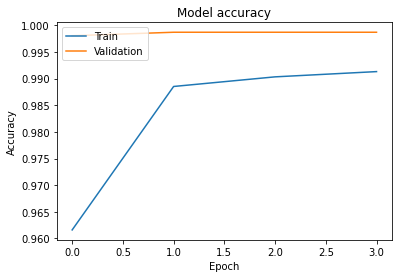

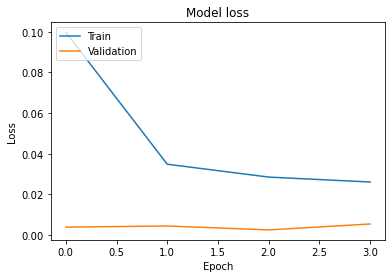

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [12]:
#Load the saved model
saved_model = tf.keras.models.load_model('./dataset/saved/model_mobilenet.h5')

In [13]:
#Make predictions on the test data
test_loss, test_accuracy = saved_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

191/191 [==============================] - 29s 149ms/step - loss: 0.0055 - accuracy: 0.9987
Test loss: 0.005464654415845871
Test accuracy: 0.9986876845359802


In [20]:
#Get the predictions and true labels for the test data
test_pred = saved_model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_generator.classes

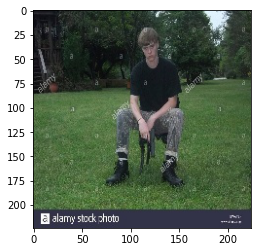

The predicted class is: firearm


In [16]:
from tensorflow.keras.preprocessing import image

# load the sample image and preprocess it
img_path = './dataset/data/armas (226).jpg'
img = image.load_img(img_path, target_size=IMAGE_SIZE)
plt.imshow(img)  # display the image
plt.show()
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# predict the class of the image
pred = model_mobilenet.predict(img_array)
class_idx = np.argmax(pred, axis=1)
class_label = train_generator.class_indices
class_label = dict((v,k) for k,v in class_label.items())
pred_class = class_label[class_idx[0]]
print('The predicted class is:', pred_class)

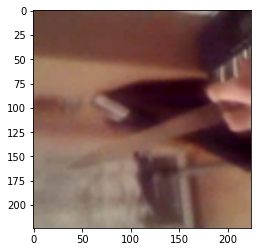

The predicted class is: knife


In [18]:
from tensorflow.keras.preprocessing import image

# load the sample image and preprocess it
img_path = './dataset/data/13518.jpg'
img = image.load_img(img_path, target_size=IMAGE_SIZE)
plt.imshow(img)  # display the image
plt.show()
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# predict the class of the image
pred = model_mobilenet.predict(img_array)
class_idx = np.argmax(pred, axis=1)
class_label = train_generator.class_indices
class_label = dict((v,k) for k,v in class_label.items())
pred_class = class_label[class_idx[0]]
print('The predicted class is:', pred_class)

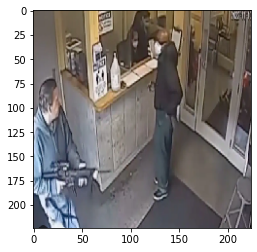

The predicted class is: firearm
Time taken for prediction: 0.08080244064331055 seconds


In [19]:
from tensorflow.keras.preprocessing import image
import time

# load the sample image and preprocess it
# This image is not in training or testing dataset


img_path = './dataset/data/1234.png'
img = image.load_img(img_path, target_size=IMAGE_SIZE)
plt.imshow(img)  # display the image
plt.show()
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# predict the class of the image
start_time = time.time()
pred = model_mobilenet.predict(img_array)
end_time = time.time()

class_idx = np.argmax(pred, axis=1)
class_label = train_generator.class_indices
class_label = dict((v,k) for k,v in class_label.items())
pred_class = class_label[class_idx[0]]
print('The predicted class is:', pred_class)
print('Time taken for prediction:', end_time - start_time, 'seconds')
